## 翻译语料筛选和处理

语料来源: [United Nations Parallel Corpus](https://conferences.unite.un.org/UNCorpus)

In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np

from data_helpers import (
    buckets, _PAD, _GO, _EOS, _UNK, _PAD_ID, _GO_ID, _EOS_ID, _UNK_ID,
    read_sentences, build_vocab, add_go_and_eos_tokens, bucket_and_pad,
    unk_proportion, unk_proportions)

%matplotlib inline

### 语料读取参数

In [2]:
local_test = False

if local_test:
    lines_to_read_train = 8000  # 取0表示读取整个文件
    lines_to_read_dev = 8000  # 取0表示读取整个文件
    vocab_min_freq_enc = 3  # 计入词表的最小词频, 小于此值则记为 UNK
    vocab_min_freq_dec = 4  # 计入词表的最小词频, 小于此值则记为 UNK
    unk_limit = 0.2  # UNK 在句子中比例的限值
else:
    lines_to_read_train = 1600000  # 取0表示读取整个文件
    lines_to_read_dev = 80000  # 取0表示读取整个文件
    vocab_min_freq_enc = 7  # 计入词表的最小词频, 小于此值则记为 UNK
    vocab_min_freq_dec = 8  # 计入词表的最小词频, 小于此值则记为 UNK
    unk_limit = 0.1  # UNK 在句子中比例的限值
    
basedir = '^data/'
files = {'from': basedir + 'UNv1.0.en-zh.en',
         'to': basedir + 'UNv1.0.en-zh.zh'}

### 读取文件, tokenize 得到 sentences (word lists)

In [5]:
encoder_sentences, decoder_sentences = read_sentences(
    files['from'], files['to'], 
    start_from=0, 
    lines_to_read=lines_to_read_train)

if local_test:
    encoder_sentences_test, decoder_sentences_test = read_sentences(
        files['from'], files['to'], 
        start_from= 0,
        lines_to_read=lines_to_read_dev)
else:
    encoder_sentences_test, decoder_sentences_test = read_sentences(
        files['from'], files['to'], 
        start_from= lines_to_read_train + 1000000,  # 测试集隔开一定距离
        lines_to_read=lines_to_read_dev)    

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.107 seconds.
Prefix dict has been built succesfully.


=========10000=========20000=========30000=========40000=========50000=========60000=========70000=========80000=========90000=========100000=========110000=========120000=========130000=========140000=========150000=========160000=========170000=========180000=========190000=========200000=========210000=========220000=========230000=========240000=========250000=========260000=========270000=========280000=========290000=========300000=========310000=========320000=========330000=========340000=========350000=========360000=========370000=========380000=========390000=========400000=========410000=========420000=========430000=========440000=========450000=========460000=========470000=========480000=========490000=========500000=========510000=========520000=========530000=========540000=========550000=========560000=========570000e=========580000=========590000=========600000=========610000=========620000=========630000=========640000=========650000=========660000=========670000===

In [6]:
len(encoder_sentences), len(decoder_sentences)

(214236, 214236)

### 查看句子长度分布

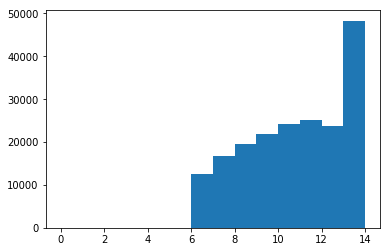

In [7]:
def plot_length_histogram(sentences):
    lengths = np.asarray([len(s) for s in sentences])
    max_len = np.max(lengths)
    plt.hist(lengths, bins=range(0, max_len, int(max_len/20) or 1));

plot_length_histogram(encoder_sentences)

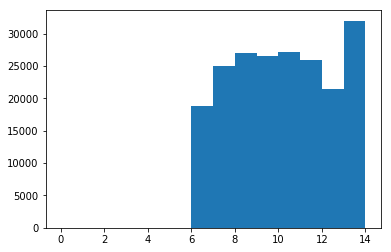

In [8]:
plot_length_histogram(decoder_sentences)

### 由训练语料得到 vocab

In [9]:
# vocab_xxx 相当于 demo 代码里的 reversed_vocab
vocab_enc = build_vocab(encoder_sentences, vocab_min_freq_enc)  # list: id -> word
vocab_dec = build_vocab(decoder_sentences, vocab_min_freq_dec)
num_encoder_symbols = len(vocab_enc)
num_decoder_symbols = len(vocab_dec)

# wod2id_xxx 相当于 demo 代码里的 vocab
word2id_enc = {w: i for i, w in enumerate(vocab_enc)}  # dict: word -> id
word2id_dec = {w: i for i, w in enumerate(vocab_dec)}

print(num_encoder_symbols, num_decoder_symbols)

7655 10340


### decoder inputs 句子首尾加 token

In [10]:
decoder_sentences = add_go_and_eos_tokens(decoder_sentences)
decoder_sentences_test = add_go_and_eos_tokens(decoder_sentences_test)

In [11]:
# print_(encoder_sentences)
# print_(decoder_sentences)

### 查看句子情况

In [12]:
check_sentences_every = 50 if local_test else 500

for s in encoder_sentences[::check_sentences_every]:
    print('**' + ' '.join(s[:]))

**reaffirm it commit to the uniti and territori integr of rwanda ,
**VI . bodi protect human right
**intern cooper in the peac use of outer space :
**It consist of a two-way audio channel and one-way black and white video link .
**● materi , fluid and bio-scienc in micrograv
**agenda item 97 : environ and sustain develop ( continu )
**A . transact cover by the guid 1-2 2
**fluent in english and french , work knowledg of spanish .
**primari health care is given prioriti in the organ of these region offic .
**140 . children with disabl are oblig to attend school , like other children .
**( d ) insuffici pedagog work in medic univers and colleg ;
**323 . the draft resolut wa adopt without a vote .
**thi report provid a summari of the respons receiv from 57 countri .
**the clearli state goal is " zero immigr " .
**It is report that it is dure such detent that disappear most frequent occur .
**follow—up to case dealt with in previou report
**undcp will place increas emphasi on the achiev of

In [13]:
for s in decoder_sentences[::check_sentences_every]:
    print('**' + ' '.join(s[1:-1]))

**重申 承诺 维护 卢旺达 的 统一 和 领土完整 ,
**六 . 保护 人权 的 机构
**和平利用 外层空间 的 国际 合作 :
**它 包括 一个双 路 音频 道 和 单路 黑白 视频 线路 。
**微重力 学 的 材料 、 液体 和 生物科学
**议程 项目 97 : 环境 与 可 持续 发展 ( 续 )
**A . 本 指南 所 包括 的 交易 .
**英语 和 法语 流利 , 西班牙语 能 应付 工作 。
**基础 卫生保健 是 组建 这些 地区 卫生局 时 首先 考虑 的 问题 。
**140 . 残疾儿童 与 其他 儿童 一样 也 必须 上学 就读 。
**医科大学 和 学院 的 理论 学习 不够 ;
**323 . 决议 草案 未经 表决 获得 通过 。
**22 本 报告 提供 了 从 57 个 国家 家家 收到 的 答复 摘要 。
**" 移民 零增长 " 是 他们 明确 宣布 的 目标 。
**据报 , 正是 在 这样 的 拘留 之下 最 常 发生 失踪 。
**关于 此前 报告 提及 案件 的 进一步 消息
**禁毒署 将 主要 注重 于 实现 各项 禁毒 目标 。
**附件 一 开幕 发言 摘要 32
**五 . 到 2000 年 全球 住房 战略 : 1998 - 1999 年 行动计划
**另有 一些 会员国 持 反对 意见 。
**国际 支助 渔业 工人 合作 会
**这 两人 为了 她 争吵 起来 。
**第 21 条 . 授权 同 外国 法院 和 外国 代表 合作 和 直接 联系
**( d ) 塞拉利昂 难民 的 遣返
**这 造成 了 暴力 和 反 暴力 。
**这些 信息 也 可 在 互联网络 上 得到 。
**30 . 建议 1999 年 进行 下列 活动 :
**13 . 资金 累积 是 经济 成长 的 一个 关键因素 。
**若干 欧洲 的 研究 报告 则 侧重 过境 和 接受方 。
**3 . 近年来 世界 上 发生 了 许多 重大 变化 。
**第 27 D 款 : 支助 事务 ( 续 )
**这是 一个 全世界 都 必须 严肃 对待 的 问题 。
**[ 根据 第六 委员会 的 报告 ( A / 51 / 628 ) 通过 ]
**持 定期 任用 合同 的 各类 工作人员 也 发挥 着 重要 作用 。
**1

### tokens -> ids -> bucketing -> padding

In [14]:
encoder_data_raw, decoder_data_raw = bucket_and_pad(
    encoder_sentences, decoder_sentences, buckets, word2id_enc, word2id_dec)
encoder_data_test_raw, decoder_data_test_raw = bucket_and_pad(
    encoder_sentences_test, decoder_sentences_test, buckets, word2id_enc, word2id_dec)

data_sizes_raw = [len(encoder_data_raw[i]) for i in range(len(buckets))]
data_sizes_dec_raw = [len(decoder_data_raw[i]) for i in range(len(buckets))]
assert data_sizes_raw == data_sizes_dec_raw

data_sizes_test_raw = [len(encoder_data_test_raw[i]) for i in range(len(buckets))]

print(data_sizes_raw)
print(data_sizes_test_raw)

[78273, 111605]
[3252, 4617]


### 查看 unk 比例, 去除 unk 比例较高的句子

In [15]:
def check(sentences, limit=0.1):
    proportions = unk_proportions(sentences)
    plt.hist(proportions, bins=[i*0.01 for i in range(20)])
    print('unk proportion < {}: {}'.format(
        limit, 
        sum([int(i <= limit) for i in proportions]) / len(sentences)))

unk proportion < 0.05: 0.8634139486157424


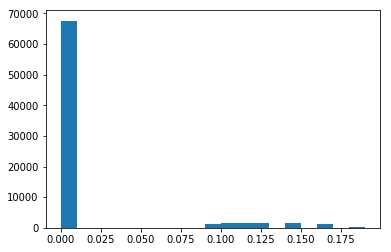

In [21]:
unk_limit = 0.05
check(encoder_data_raw[0], unk_limit)

unk proportion < 0.05: 0.7940056449083822


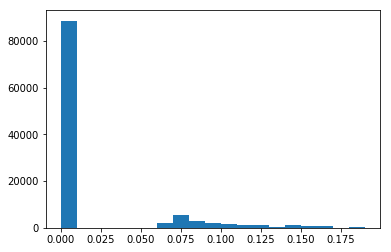

In [22]:
check(encoder_data_raw[1], unk_limit)

In [23]:
encoder_data = [[] for _ in range(len(buckets))]
decoder_data = [[] for _ in range(len(buckets))]

for bucket_id in range(len(buckets)):
    for (cur_enc_data, cur_dec_data) in zip(encoder_data_raw[bucket_id],
                                            decoder_data_raw[bucket_id]):
        if (unk_proportion(cur_enc_data) < unk_limit and unk_proportion(cur_dec_data) < unk_limit):
            encoder_data[bucket_id].append(cur_enc_data)
            decoder_data[bucket_id].append(cur_dec_data)

data_sizes = [len(encoder_data[i]) for i in range(len(buckets))]
data_sizes_dec = [len(decoder_data[i]) for i in range(len(buckets))]
assert data_sizes == data_sizes_dec

data_sizes

[59648, 71510]

In [26]:
encoder_data_test = [[] for _ in range(len(buckets))]
decoder_data_test = [[] for _ in range(len(buckets))]

for bucket_id in range(len(buckets)):
    for (cur_enc_data, cur_dec_data) in zip(encoder_data_test_raw[bucket_id],
                                            decoder_data_test_raw[bucket_id]):
        if (unk_proportion(cur_enc_data) < unk_limit and unk_proportion(cur_dec_data) < unk_limit):
            encoder_data_test[bucket_id].append(cur_enc_data)
            decoder_data_test[bucket_id].append(cur_dec_data)

data_sizes_test = [len(encoder_data_test[i]) for i in range(len(buckets))]
data_sizes_dec_test = [len(decoder_data_test[i]) for i in range(len(buckets))]
assert data_sizes_test == data_sizes_dec_test

data_sizes_test

[2439, 3004]

In [51]:
with open('sentences_13w.pkl', 'wb') as f:
    pickle.dump([encoder_sentences, decoder_sentences,
                 encoder_sentences_test, decoder_sentences_test], f)

with open('data_13w.pkl', 'wb') as f:
    pickle.dump([encoder_data, decoder_data,
                 encoder_data_test, decoder_data_test], f)

with open('vocab_13w.pkl', 'wb') as f:
    pickle.dump([vocab_enc, vocab_dec], f)

### Note

- UNK 的处理
    - [此文](http://suriyadeepan.github.io/2016-12-31-practical-seq2seq/) 建议 UNK 在语料(不是词表)中的比例控制在 5% 以内.